In [1]:
import pandas as pd
import numpy as np

In [3]:
GC_df_16 = pd.read_csv(r"../util/data/FY2016/structured/original/GuilfordCountyOriginalDataFY16.csv")
GC_df_16.drop(['Unnamed: 0'], axis=1,inplace=True)
GC_df_16.head(5)

,page_number,word
0,1,fy
1,1,adopted
2,1,budget
3,1,july
4,1,june


In [4]:
import sys
# !{sys.executable} -m spacy download en
import re, numpy as np, pandas as pd
from pprint import pprint

# Gensim
import gensim, spacy, logging, warnings
import gensim.corpora as corpora
from gensim.utils import lemmatize, simple_preprocess
from gensim.models import CoherenceModel
import matplotlib.pyplot as plt

# NLTK Stop words
from nltk.corpus import stopwords
stop_words = stopwords.words('english')
stop_words.extend(['from', 'subject', 're', 'edu', 'use', 'not', 'would', 'say', 'could', '_', 'be', 'know', 'good', 'go', 'get', 'do', 'done', 'try', 'many', 'some', 'nice', 'thank', 'think', 'see', 'rather', 'easy', 'easily', 'lot', 'lack', 'make', 'want', 'seem', 'run', 'need', 'even', 'right', 'line', 'even', 'also', 'may', 'take', 'come'])

%matplotlib inline
warnings.filterwarnings("ignore",category=DeprecationWarning)
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.ERROR)

In [5]:
def sent_to_words(sentences):
    for sent in sentences:
        sent = re.sub('\S*@\S*\s?', '', sent)  # remove emails
        sent = re.sub('\s+', ' ', sent)  # remove newline chars
        sent = re.sub("\'", "", sent)  # remove single quotes
        sent = gensim.utils.simple_preprocess(str(sent), deacc=True) 
        yield(sent)  

# Convert to list
data = GC_df_12.word.values.tolist()
data_words = list(sent_to_words(data))
print(data_words[:1])
# [['from', 'irwin', 'arnstein', 'subject', 're', 'recommendation', 'on', 'duc', 'summary', 'whats', 'it', 'worth', 'distribution', 'usa', 'expires', 'sat', 'may', 'gmt', ...trucated...]]

[['fy']]


In [6]:
# Build the bigram and trigram models
bigram = gensim.models.Phrases(data_words, min_count=5, threshold=100) # higher threshold fewer phrases.
trigram = gensim.models.Phrases(bigram[data_words], threshold=100)  
bigram_mod = gensim.models.phrases.Phraser(bigram)
trigram_mod = gensim.models.phrases.Phraser(trigram)

# !python3 -m spacy download en  # run in terminal once
def process_words(texts, stop_words=stop_words, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']):
    """Remove Stopwords, Form Bigrams, Trigrams and Lemmatization"""
    texts = [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in texts]
    texts = [bigram_mod[doc] for doc in texts]
    texts = [trigram_mod[bigram_mod[doc]] for doc in texts]
    texts_out = []
    nlp = spacy.load('en', disable=['parser', 'ner'])
    for sent in texts:
        doc = nlp(" ".join(sent)) 
        texts_out.append([token.lemma_ for token in doc if token.pos_ in allowed_postags])
    # remove stopwords once more after lemmatization
    texts_out = [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in texts_out]    
    return texts_out

data_ready = process_words(data_words)  # processed Text Data!

In [7]:
# Create Dictionary
id2word = corpora.Dictionary(data_ready)

# Create Corpus: Term Document Frequency
corpus = [id2word.doc2bow(text) for text in data_ready]

# Build LDA model
lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=10, 
                                           passes=10,
                                           alpha = 'auto',
                                           eta = 'auto',
                                           random_state = 1)

pprint(lda_model.print_topics())

[(0,
  '0.129*"capital" + 0.099*"adopt" + 0.096*"funding" + 0.079*"ordinance" + '
  '0.069*"operate" + 0.054*"commissioner" + 0.045*"enforcement" + '
  '0.045*"college" + 0.033*"issue" + 0.030*"education"'),
 (1,
  '0.357*"fire" + 0.119*"revenue" + 0.056*"program" + 0.049*"system" + '
  '0.043*"state" + 0.037*"time" + 0.036*"park" + 0.027*"priority" + '
  '0.023*"department" + 0.022*"population"'),
 (2,
  '0.125*"development" + 0.125*"tax" + 0.114*"include" + 0.078*"fiscal" + '
  '0.044*"follow" + 0.043*"continue" + 0.040*"bond" + 0.033*"planning" + '
  '0.031*"replacement" + 0.027*"room"'),
 (3,
  '0.140*"community" + 0.084*"construction" + 0.081*"economic" + '
  '0.079*"provide" + 0.069*"debt" + 0.066*"estimate" + 0.053*"change" + '
  '0.046*"actual" + 0.033*"resource" + 0.031*"recommend"'),
 (4,
  '0.209*"total" + 0.182*"protection" + 0.108*"high" + 0.047*"rate" + '
  '0.043*"work" + 0.030*"government" + 0.030*"additional" + 0.025*"finance" + '
  '0.025*"source" + 0.022*"taxis"'),
 

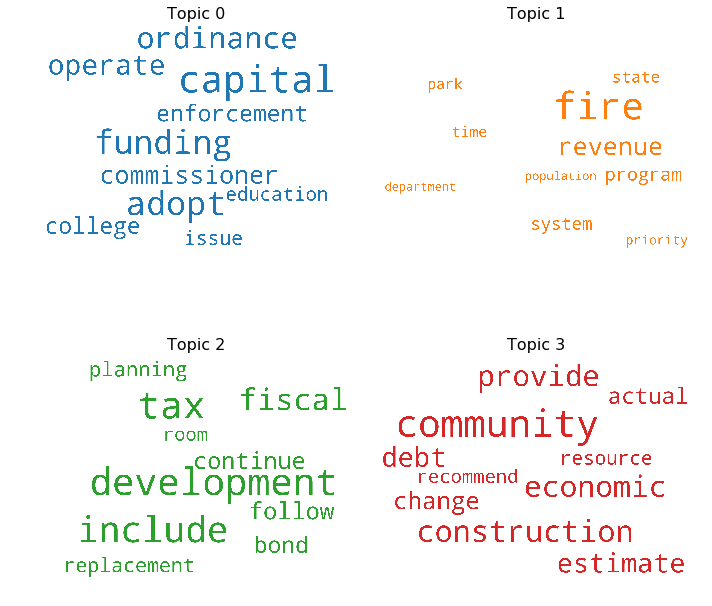

In [10]:
# 1. Wordcloud of Top N words in each topic
from matplotlib import pyplot as plt
from wordcloud import WordCloud, STOPWORDS
import matplotlib.colors as mcolors

cols = [color for name, color in mcolors.TABLEAU_COLORS.items()]  # more colors: 'mcolors.XKCD_COLORS'

cloud = WordCloud(stopwords=stop_words,
                  background_color='white',
                  width=2500,
                  height=1800,
                  max_words=10,
                  colormap='tab10',
                  color_func=lambda *args, **kwargs: cols[i],
                  prefer_horizontal=1.0)

topics = lda_model.show_topics(formatted=False)

fig, axes = plt.subplots(2, 2, figsize=(10,10), sharex=True, sharey=True)

for i, ax in enumerate(axes.flatten()):
    fig.add_subplot(ax)
    topic_words = dict(topics[i][1])
    cloud.generate_from_frequencies(topic_words, max_font_size=300)
    plt.gca().imshow(cloud)
    plt.gca().set_title('Topic ' + str(i), fontdict=dict(size=16))
    plt.gca().axis('off')


plt.subplots_adjust(wspace=0, hspace=0)
plt.axis('off')
plt.margins(x=0, y=0)
plt.tight_layout()
plt.show()

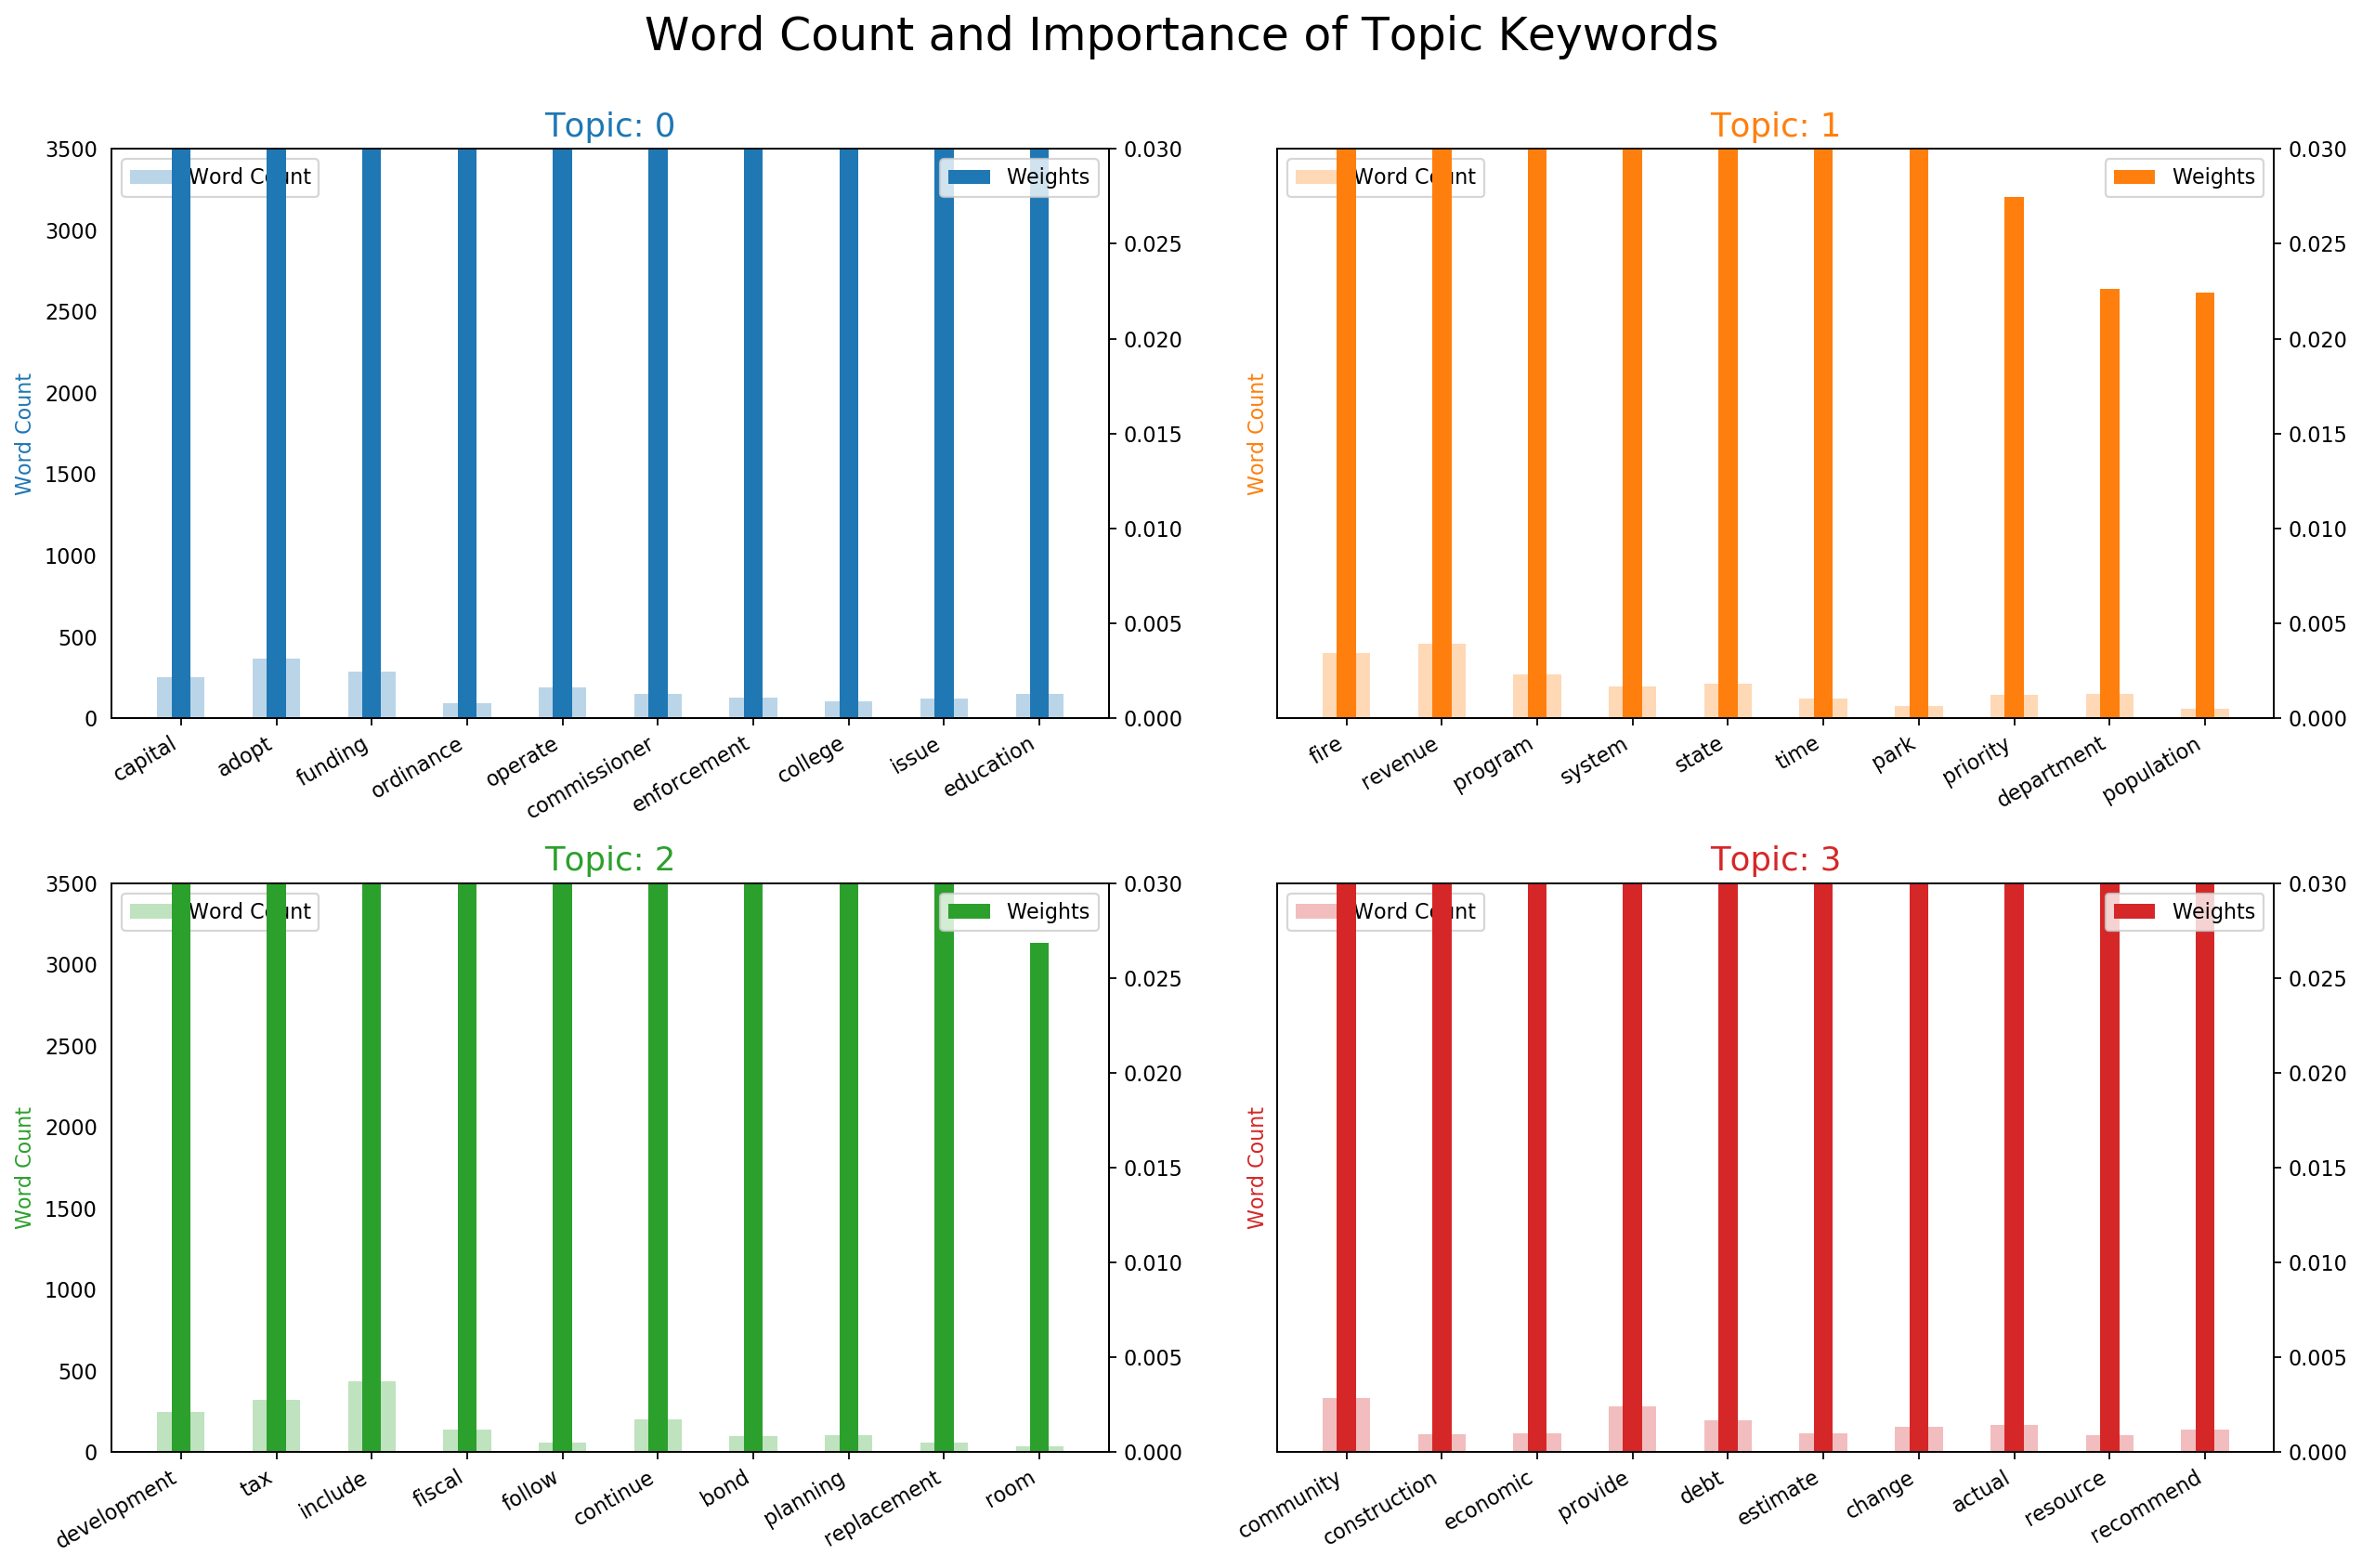

In [11]:
from collections import Counter
topics = lda_model.show_topics(formatted=False)
data_flat = [w for w_list in data_ready for w in w_list]
counter = Counter(data_flat)

out = []
for i, topic in topics:
    for word, weight in topic:
        out.append([word, i , weight, counter[word]])

df = pd.DataFrame(out, columns=['word', 'topic_id', 'importance', 'word_count'])        

# Plot Word Count and Weights of Topic Keywords
fig, axes = plt.subplots(2, 2, figsize=(16,10), sharey=True, dpi=160)
cols = [color for name, color in mcolors.TABLEAU_COLORS.items()]
for i, ax in enumerate(axes.flatten()):
    ax.bar(x='word', height="word_count", data=df.loc[df.topic_id==i, :], color=cols[i], width=0.5, alpha=0.3, label='Word Count')
    ax_twin = ax.twinx()
    ax_twin.bar(x='word', height="importance", data=df.loc[df.topic_id==i, :], color=cols[i], width=0.2, label='Weights')
    ax.set_ylabel('Word Count', color=cols[i])
    ax_twin.set_ylim(0, 0.030); ax.set_ylim(0, 3500)
    ax.set_title('Topic: ' + str(i), color=cols[i], fontsize=16)
    ax.tick_params(axis='y', left=False)
    ax.set_xticklabels(df.loc[df.topic_id==i, 'word'], rotation=30, horizontalalignment= 'right')
    ax.legend(loc='upper left'); ax_twin.legend(loc='upper right')

fig.tight_layout(w_pad=2)    
fig.suptitle('Word Count and Importance of Topic Keywords', fontsize=22, y=1.05)    
plt.show()

In [13]:
import pyLDAvis.gensim
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(lda_model, corpus, dictionary=lda_model.id2word)
vis

/anaconda3/lib/python3.6/site-packages/pyLDAvis/_prepare.py:257: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  return pd.concat([default_term_info] + list(topic_dfs))


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
9     -0.347585  0.192371       1        1  40.599327
8      0.013803 -0.059779       2        1   7.775924
1      0.262605  0.328926       3        1   7.603931
2      0.074949 -0.161972       4        1   7.297661
0      0.035727 -0.084953       5        1   6.865594
4      0.050065 -0.111863       6        1   6.790862
3     -0.013255 -0.033159       7        1   6.511261
5     -0.016417 -0.030355       8        1   6.059467
6     -0.025892 -0.022604       9        1   6.023254
7     -0.033999 -0.016611      10        1   4.472715, topic_info=     Category         Freq             Term        Total  loglift  logprob
term                                                                      
147   Default  1163.000000             fire  1163.000000  30.0000  30.0000
3     Default   662.000000             year   662.000000  29.0000  29.0000
1     Default   689.000000           budget   689.000000  28.0000  28.0000
282   Default   609.000000            total   609.000000  27.0000  27.0000
150   Default   530.000000       protection   530.000000  26.0000  26.0000
81    Default   514.000000             fund   514.000000  25.0000  25.0000
95    Default   359.000000           school   359.000000  24.0000  24.0000
77    Default   392.000000        community   392.000000  23.0000  23.0000
57    Default   392.000000      development   392.000000  22.0000  22.0000
79    Default   392.000000              tax   392.000000  21.0000  21.0000
142   Default   380.000000          capital   380.000000  20.0000  20.0000
64    Default   389.000000          revenue   389.000000  19.0000  19.0000
267   Default   357.000000          include   357.000000  18.0000  18.0000
182   Default   320.000000         increase   320.000000  17.0000  17.0000
121   Default   340.000000         facility   340.000000  16.0000  16.0000
188   Default   315.000000             high   315.000000  15.0000  15.0000
74    Default   957.000000          service   957.000000  14.0000  14.0000
0     Default   293.000000            adopt   293.000000  13.0000  13.0000
75    Default   279.000000           public   279.000000  12.0000  12.0000
281   Default   283.000000          funding   283.000000  11.0000  11.0000
309   Default   236.000000     construction   236.000000  10.0000  10.0000
2     Default   244.000000           fiscal   244.000000   9.0000   9.0000
130   Default   228.000000         economic   228.000000   8.0000   8.0000
165   Default   232.000000        ordinance   232.000000   7.0000   7.0000
118   Default   199.000000              law   199.000000   6.0000   6.0000
280   Default   220.000000          provide   220.000000   5.0000   5.0000
315   Default   190.000000            staff   190.000000   4.0000   4.0000
115   Default   198.000000        emergency   198.000000   3.0000   3.0000
287   Default   178.000000      appropriate   178.000000   2.0000   2.0000
244   Default   204.000000          operate   204.000000   1.0000   1.0000
...       ...          ...              ...          ...      ...      ...
361   Topic10     0.106494       comparable     1.098949   0.7732  -9.7979
362   Topic10     0.106494           likely     1.098949   0.7732  -9.7979
630   Topic10     0.106494              bad     1.098953   0.7732  -9.7979
568   Topic10     0.106494          roughly     1.098953   0.7732  -9.7979
644   Topic10     0.106494     appreciation     1.098953   0.7732  -9.7979
650   Topic10     0.106494        adaptable     1.098953   0.7732  -9.7979
632   Topic10     0.106494         scenario     1.098953   0.7732  -9.7979
635   Topic10     0.106494      legislature     1.098953   0.7732  -9.7979
642   Topic10     0.106494       dependable     1.098953   0.7732  -9.7979
679   Topic10     0.106494        delineate     1.098953   0.7732  -9.7979
788   Topic10     0.106494     coordinative     1.098963   0.7731  -9.7979
719   Top

In [14]:
dictionary=corpora.Dictionary(data_ready)

In [15]:
from gensim.models.coherencemodel import CoherenceModel
coherence_model_lda = CoherenceModel(model=lda_model, texts=data_ready, dictionary=dictionary, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('\nCoherence Score: ', coherence_lda)


Coherence Score:  0.8259843089417818


In [16]:
def compute_coherence_values(dictionary, corpus, texts, limit, start=2, step=3):
    coherence_values = []
    model_list = []
    for num_topics in range(start, limit, step):
        model=LdaModel(corpus=corpus, id2word=dictionary, num_topics=num_topics)
        model_list.append(model)
        coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())

    return model_list, coherence_values

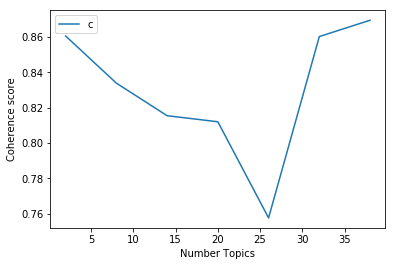

In [17]:
from gensim.models.ldamodel import LdaModel
model_list, coherence_values = compute_coherence_values(dictionary=dictionary, corpus=corpus, texts=data_ready, start=2, limit=40, step=6)
# Graphs shows the optimal number of topics
import matplotlib.pyplot as plt
%matplotlib inline
limit=40; start=2; step=6;
x = range(start, limit, step)
plt.plot(x, coherence_values)
plt.xlabel("Number Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.show()